# Obtain your API key

You can access your Materials Project API key at https://next-gen.materialsproject.org/api

If you do not have an account yet, you will see the following button.
Simply click it and follow the instructions to obtain your API key.
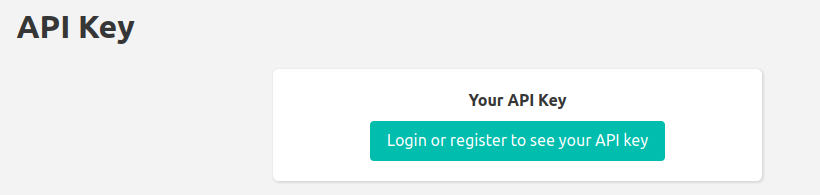


In [27]:
API_KEY = "[YOUR API KEY]"

These packages heavily depend on the `pymatgen` package so please first follow the instructions [here](https://pymatgen.org/installation.html) to install pymatgen (it is recommended that you set up a virtual environment using `conda` as part of this process).

Instructions for installing and setting up the `Jupyter` notebook environment can be found [here](https://jupyter.org/install)

Then you should install the following two packages:

```
pip install -U mp-api
pip install -U mp-pyrho
```

To test that the installation was completed properly run the following commands and the output should be `pymatgen.io.vasp.outputs.Chgcar`

In [29]:
from mp_api import MPRester
with MPRester(API_KEY) as mpr:
    chgcar = mpr.get_charge_density_from_material_id("mp-149")
type(chgcar)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

pymatgen.io.vasp.outputs.Chgcar

To obtain the inputs for a calculation, the `inc_task_doc` parameter can be set to `True`.  This returns a `TaskDocument` object, which represents the parsed directory of a VASP calculation.
The inputs used are attributes of this `TaskDocument` object and can be accessed in the follow fashion: 

In [30]:
chgcar, task = mpr.get_charge_density_from_material_id("mp-149", inc_task_doc=True)
print(f"INCAR: class -> {type(task.orig_inputs.incar)}")
print(task.orig_inputs.incar)
print(f"POSCAR: class -> {type(task.orig_inputs.poscar)}")
print(task.orig_inputs.poscar)
print(f"KPOINTS: class -> {type(task.orig_inputs.incar)}")
print(task.orig_inputs.kpoints)
print(f"POTCAR: class -> {type(task.orig_inputs.potcar)}")
print(task.orig_inputs.potcar)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving TaskDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

INCAR: class -> <class 'pymatgen.io.vasp.inputs.Incar'>
ADDGRID = True
ALGO = Normal
EDIFF = 5e-05
ENCUT = 520
IBRION = -1
ISIF = 3
ISMEAR = -5
ISPIN = 2
LAECHG = True
LASPH = True
LCHARG = True
LORBIT = 11
LREAL = Auto
LVHAR = True
LWAVE = False
MAGMOM = 2*0.6
NELM = 100
NSW = 0
PREC = Accurate
SIGMA = 0.05

POSCAR: class -> <class 'pymatgen.io.vasp.inputs.Poscar'>
Si2
1.0
0.000000 2.734364 2.734364
2.734364 0.000000 2.734364
2.734364 2.734364 0.000000
Si
2
direct
0.250000 0.250000 0.250000 Si
0.000000 0.000000 0.000000 Si

KPOINTS: class -> <class 'pymatgen.io.vasp.inputs.Incar'>
Automatic kpoint scheme
0
Monkhorst
8 8 8

POTCAR: class -> <class 'emmet.core.tasks.Potcar'>
functional='PBE' symbols=['Si']


Since the automation framework at the Materials Project attempts to fix common VASP run failures, the exact set of VASP inputs in the final calculation might be different from the original inputs.
These outputs can be accessed via the `calcs_reversed` attribute as shown below.  Since all of the charge densities are generated with static calculations there should only be one entry in the `calcs_reversed` list.
The detailed information can be accessed using the `input` and `output` attributes.

In [33]:
task.calcs_reversed[0].input.keys()

dict_keys(['incar', 'kpoints', 'nkpoints', 'potcar', 'potcar_spec', 'potcar_type', 'parameters', 'lattice_rec', 'structure'])

In [34]:
task.calcs_reversed[0].output.keys()

dict_keys(['ionic_steps', 'efermi', 'bandgap', 'cbm', 'vbm', 'is_gap_direct', 'epsilon_static', 'epsilon_static_wolfe', 'epsilon_ionic', 'structure', 'energy', 'energy_per_atom', 'is_metal', 'direct_gap', 'eigenvalue_band_properties', 'outcar'])

# Querying for the charge density of many different structures

The `mp_api` is a full-featured REST api for all of the data on the materials project.
Its features are too numerous to list here, so we will use a basic cystal-system query to show how you can obtain all of the charge densities of the stable structures in the "Hexagonal" crystal system.

We can begin be querying for all of the stable materials in that system.
But since we are not interested in obtaining all of the material data available we can filter our query by the `material_id` field to reduce the time and network load.


In [22]:
from mp_api import MPRester
with MPRester(API_KEY) as mpr:
    hexagonal_materials = mpr.summary.search(crystal_system="Hexagonal", is_stable=True, fields=["material_id"])

Retrieving SummaryDoc documents:   0%|          | 0/3733 [00:00<?, ?it/s]

We can see how many documents were returned by the query above.

In [23]:
print(f"The query returned {len(hexagonal_materials)} documents.")

The query returned 3733 documents.


This returns a list of more than 3000 materials which is much larger, some will have charge densities available in our database some will not.
We can loop through these materials and save the charge densities we find in a folder.

In [24]:
# Create the destination folder if it is not already present
import os
if not os.path.exists('found_chgcars'):
    os.makedirs('found_chgcars')

Finally, we can loop through the different hexagonal materials and grab the charge densities in the form of a `Chgcar`.
Each `Chgcar` object is then written to a file with the name like `CHGCAR_mp-5620.vasp`.
The charge density can be viewed in Vesta and after adjusting the isosurface you should see something like this:

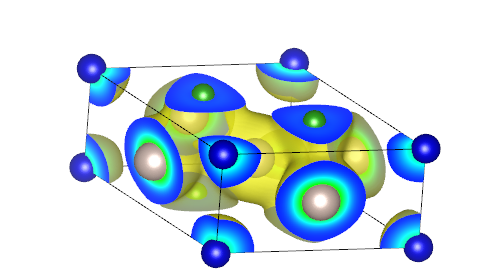


In [25]:
found_chgcar_ids = []
with MPRester(API_KEY) as mpr:
    for imat in hexagonal_materials[:10]:
        print(f"Searching for {imat.material_id}")
        chgcar = mpr.get_charge_density_from_material_id(imat.material_id)
        if chgcar is None:
            continue
        chgcar.write_file(f"./found_chgcars/CHGCAR_{imat.material_id}.vasp")
        found_chgcar_ids.append(imat.material_id)


Searching for mp-554389


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Searching for mp-1213435


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents: 0it [00:00, ?it/s]

Searching for mp-28987


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Searching for mp-1804


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Searching for mp-1079242


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Searching for mp-1217775


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Searching for mp-978102


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Searching for mp-2108


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Searching for mp-6709


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Searching for mp-1077361


Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ChgcarDataDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]